# <div align=center>Using Reinforcement Learning to Train a Computer to Play Pitfall on Atari 2600</div>

### Game Background

> Pitfall is a side scrolling action game where you have to avoid hitting logs, snakes, fire,  alligators. You must also avoid falling into any pits by either jumping onto floating obstacles or swinging on vines. Hitting a log causes you to lose points while falling in pits and getting hit by monsters kills you. The goal is to collect all 34 treasures within the 20 minute time limit.


![PitfallUrl](https://media.giphy.com/media/26ufhvIsszkJdF2Du/giphy.gif "pitfall")

### Process:

> I started off attempting to train the CNN with no replay buffer. Unfortunatly, the rewards in Pitfall are a long way off. Reading through some walkthroughs shows that the first reward is at least 12 screens away if you utalize the underground shortcuts. Without the replay buffer there was no way for my model to get far enough along to find a reward. Therefore, my first attempt resulted in my model learning that not moving at all was the best option because you didn't lose any points.

> After doing some further research I found a white paper that generalized exactly what I wanted to do. Specifically the algorithm outlined on page 5. 

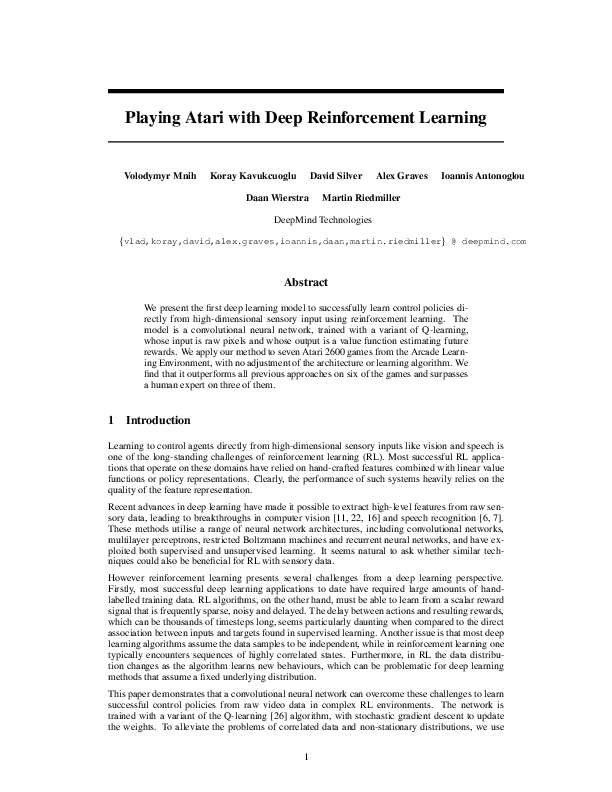

In [1]:
from wand.image import Image as WImage
img = WImage(filename='dqn.pdf[0]')
img


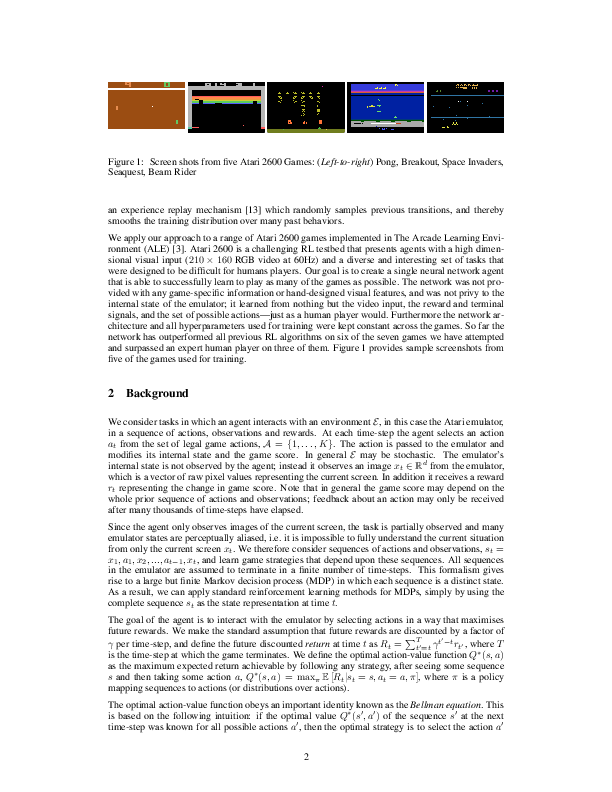

In [2]:
img = WImage(filename='dqn.pdf[1]')
img

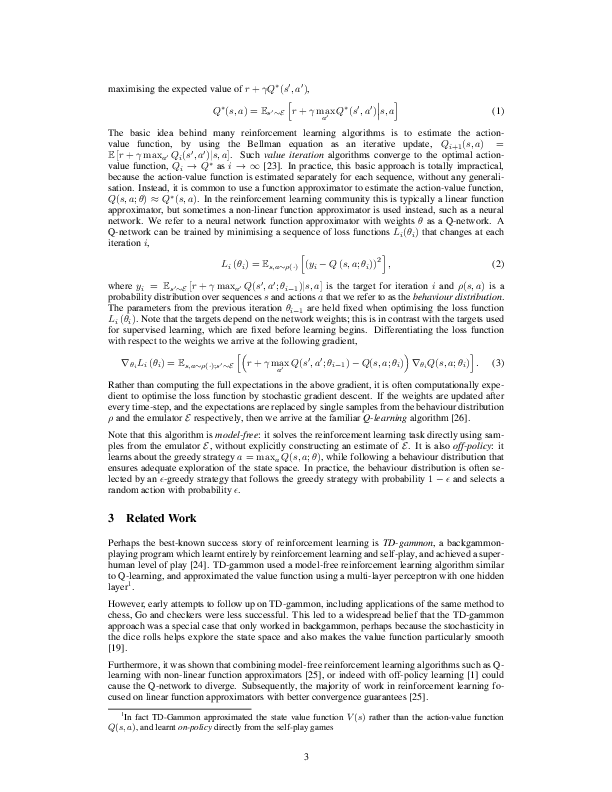

In [3]:
img = WImage(filename='dqn.pdf[2]')
img

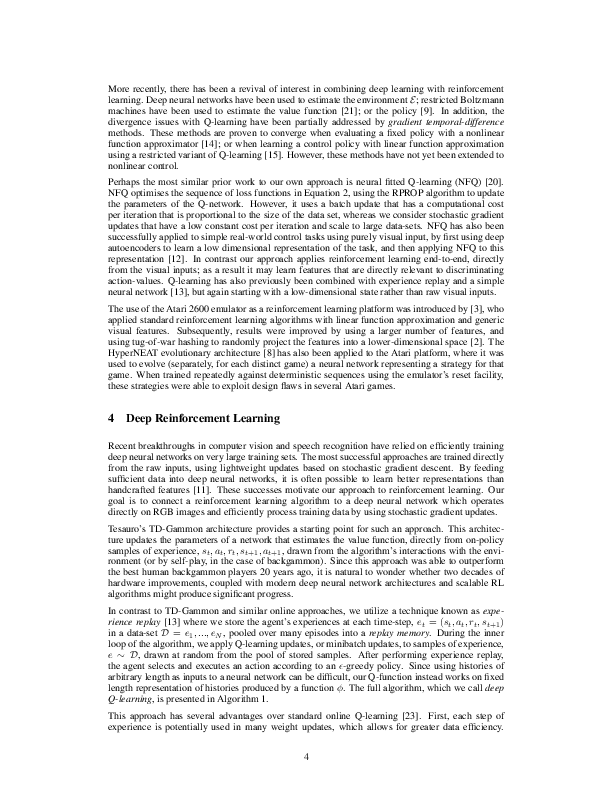

In [4]:
img = WImage(filename='dqn.pdf[3]')
img

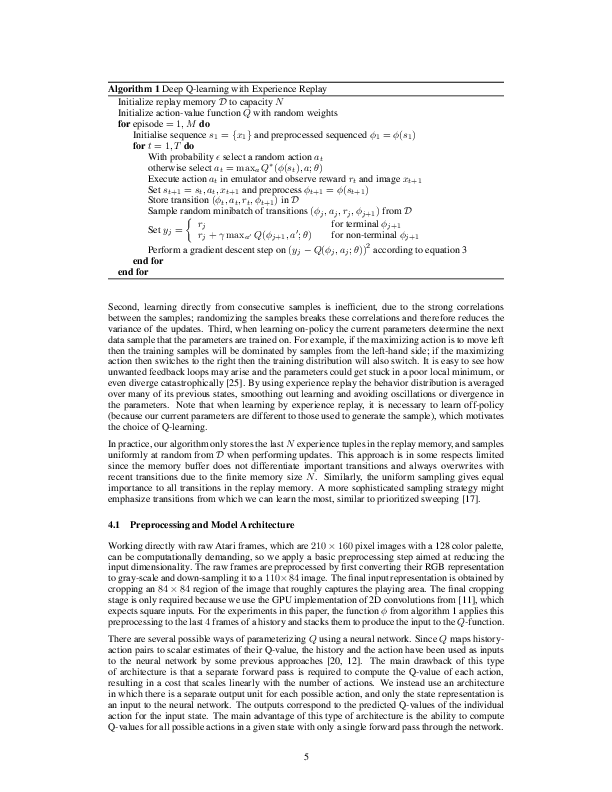

In [5]:
img = WImage(filename='dqn.pdf[4]')
img

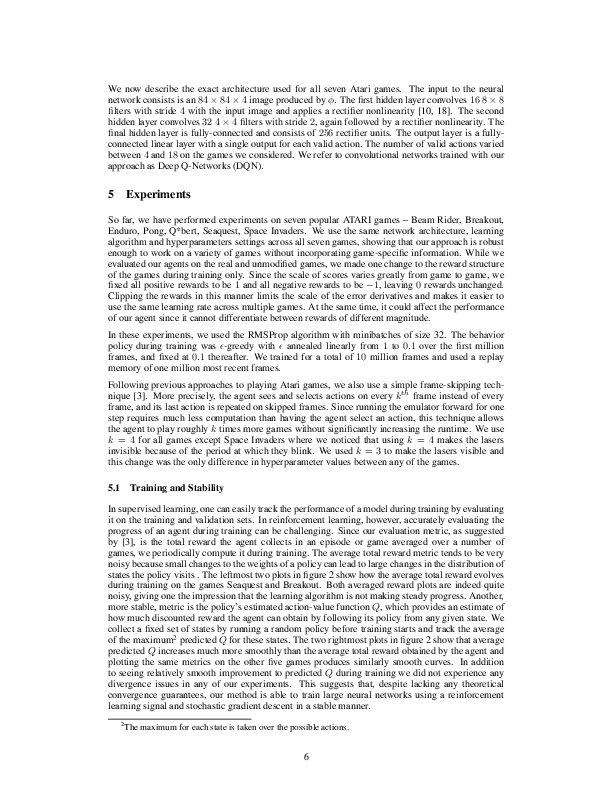

In [6]:
img = WImage(filename='dqn.pdf[5]')
img

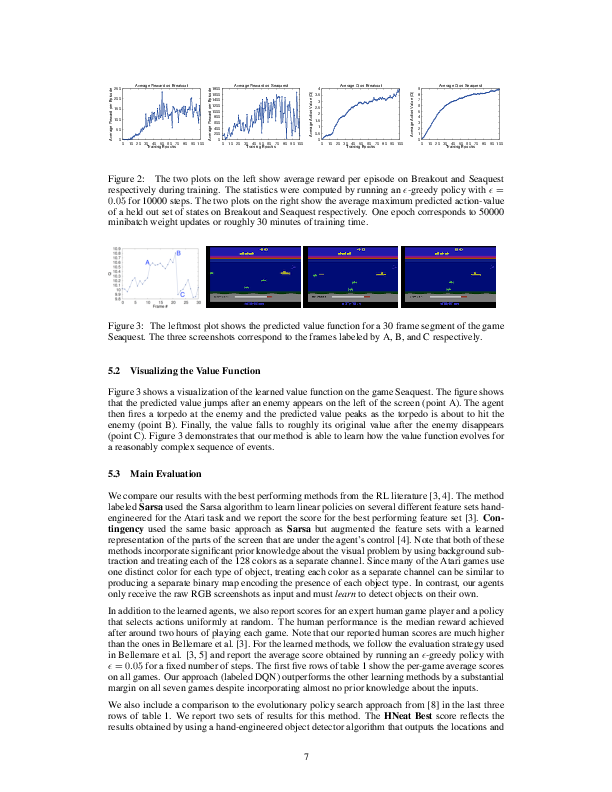

In [7]:
img = WImage(filename='dqn.pdf[6]')
img

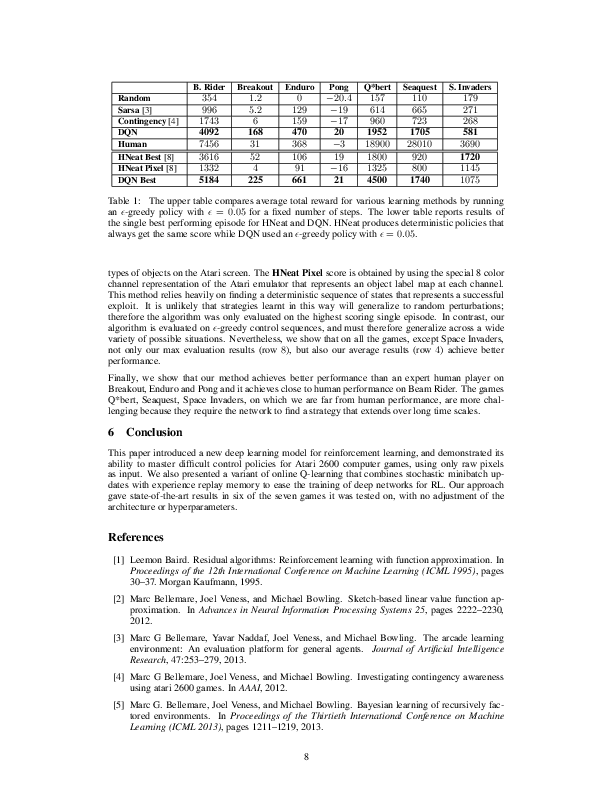

In [8]:
img = WImage(filename='dqn.pdf[7]')
img

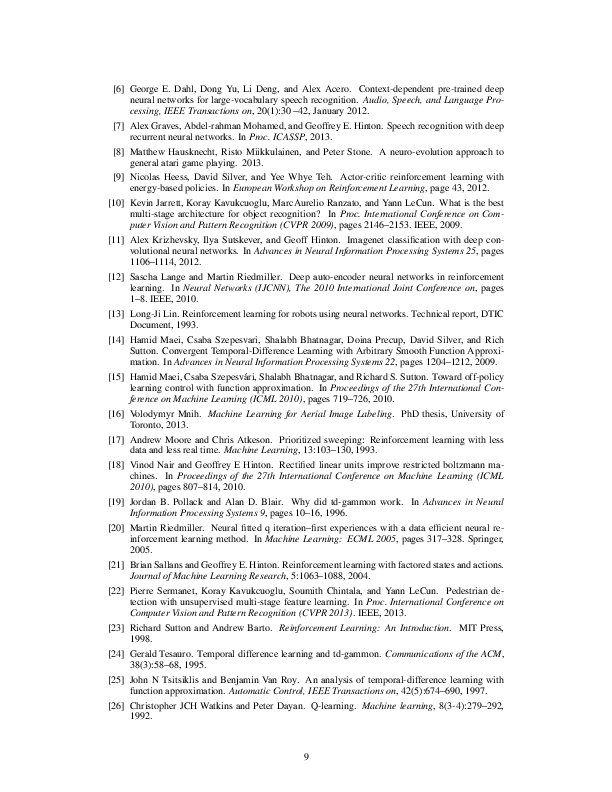

In [9]:
img = WImage(filename='dqn.pdf[8]')
img

In [10]:
1523069

1523069

I wanted to take the code that was provided for us and make it far more robust. I did this by seperating the files into a main driver file, files with classes for the model and some seperate utility function files.

In [11]:
# main driver function

# %load atari/atari.py
#!/usr/bin/env python3
import argparse
import atexit
import gym
import numpy as np
import random
import utils
from DQAgent import DQAgent
from evaluation import evaluate
from Logger import Logger
import os
import keras.backend.tensorflow_backend as tfback
import tensorflow as tf

# Added to make this work on the virtual machine
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# allows for gracefull exit 
def exit_handler():
    global DQA
    DQA.quit()

IMG_SIZE = (84, 84)
utils.IMG_SIZE = IMG_SIZE


def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).
        Code injection for updated version of Tensorflow
    # Returns
    A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus


# I/O
parser = argparse.ArgumentParser()
parser.add_argument('-t', '--train', action='store_true',
                    help='train the agent')
parser.add_argument('-l', '--load', type=str, default=None,
                    help='load a trained model')
parser.add_argument('-v', '--video', action='store_true',
                    help='show video output')
parser.add_argument('-d', '--debug', action='store_true',
                    help='run in debug mode (no output files)')
parser.add_argument('--eval', action='store_true',
                    help='evaluate the agent')
parser.add_argument('-e', '--environment', type=str,
                    help='name of the OpenAI Gym environment to use '
                    '(default: PitfallNoFrameskip-v4)',
                    default='PitfallNoFrameskip-v4')
parser.add_argument('--minibatch-size', type=int, default=32,
                    help='number of sample to train the DQN at each update')
parser.add_argument('--replay-memory-size', type=int, default=1e6,
                    help='number of samples stored in the replay memory')
parser.add_argument('--target-network-update-freq', type=int, default=10e3,
                    help='frequency (number of DQN updates) with which the '
                     'target DQN is updated')
parser.add_argument('--avg-val-computation-freq', type=int, default=50e3,
                    help='frequency (number of DQN updates) with which the '
                     'average reward and Q value are computed')
parser.add_argument('--discount-factor', type=float, default=0.99,
                    help='discount factor for the environment')
parser.add_argument('--update-freq', type=int, default=4,
                    help='frequency (number of steps) with which to train the '
                     'DQN')
parser.add_argument('--learning-rate', type=float, default=0.00025,
                    help='learning rate for optimizer')
parser.add_argument('--epsilon', type=float, default=1,
                    help='initial exploration rate for the agent')
parser.add_argument('--min-epsilon', type=float, default=0.1,
                    help='final exploration rate for the agent')
parser.add_argument('--epsilon-decrease', type=float, default=9e-7,
                    help='rate at which to linearly decrease epsilon')
parser.add_argument('--replay-start-size', type=int, default=50e3,
                    help='minimum number of transitions (with fully random '
                     'policy) to store in the replay memory before '
                     'starting training')
parser.add_argument('--initial-random-actions', type=int, default=30,
                    help='number of random actions to be performed by the agent'
                     ' at the beginning of each episode')
parser.add_argument('--dropout', type=float, default=0.,
                    help='dropout rate for the DQN')
parser.add_argument('--max-episodes', type=int, default=np.inf,
                    help='maximum number of episodes that the agent can '
                     'experience before quitting')
parser.add_argument('--max-episode-length', type=int, default=np.inf,
                    help='maximum number of steps in an episode')
parser.add_argument('--max-frames-number', type=int, default=50e6,
                     help='maximum number of frames during the whole algorithm')
parser.add_argument('--test-freq', type=int, default=250000,
                    help='frequency (number of frames) with which to test the '
                     'agent\'s performance')
parser.add_argument('--validation-frames', type=int, default=135000,
                    help='number of frames to test the model like in table 3 of'
                     ' the paper')
parser.add_argument('--test-states', type=int, default=30,
                    help='number of states on which to compute the average Q '
                     'value')
parser.add_argument('-c', '--cpu', action='store_true', 
                    help='run training on cpu instead of gpu')
args = parser.parse_args()

# runs training on cpu not gpu
if args.cpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if args.debug:
    print('####################################################' \
        'WARNING: debug flag is set, output will not be saved' \
        '####################################################')

logger = Logger(debug=args.debug, append=args.environment)

# Variables
test_scores = []
test_mean_q = []
test_states = []
n_stack = 4

# Setup
env = gym.make(args.environment)
env = gym.wrappers.AtariPreprocessing(env, terminal_on_life_loss=True, scale_obs=False)
env = gym.wrappers.FrameStack(env, n_stack)

#IMG_SIZE = (84, 84)
#IMG_SIZE = (84, 110)
network_input_shape = (4, n_stack, 84, 84)  # Dimension ordering: 'th' (channels first)
DQA = DQAgent(env.action_space.n,
    network_input_shape,
    replay_memory_size=args.replay_memory_size,
    minibatch_size=args.minibatch_size,
    learning_rate=args.learning_rate,
    discount_factor=args.discount_factor,
    dropout_prob=args.dropout,
    epsilon=args.epsilon,
    epsilon_decrease_rate=args.epsilon_decrease,
    min_epsilon=args.min_epsilon,
    load_path=args.load,
    logger=logger,
    n_stack=n_stack)

atexit.register(exit_handler)  # Make sure to always save the model when exiting

# Initial logging
logger.log({
        'Action space': env.action_space.n,
        'Observation space': env.observation_space.shape
})
logger.log(vars(args))
training_csv = 'training_info.csv'
eval_csv = 'evaluation_info.csv'
test_csv = 'test_score_mean_q_info.csv'
logger.to_csv(training_csv, 'length,score')
logger.to_csv(eval_csv, 'length,score')
logger.to_csv(test_csv, 'avg_score,avg_Q')

# Set counters
episode = 0
frame_counter = 0

if args.train:
    # Main loop
    while episode < args.max_episodes:
        # Start episode
        logger.log("Episode %d" % episode)
        # sent to logger when I was watching memory consumption
        cpu = utils.get_CPU_pct()
        logger.log("CPU Usage %s" % cpu)
        mem_G, mem_T, mem_U, mem_F = utils.get_mem()
        logger.log("Total Memory %s" % mem_T)
        logger.log("Used Memory %s" % mem_U)
        logger.log("Free Memory %s" % mem_F)
        
        score = 0

        # Observe reward and initialize first state
        #obs = utils.preprocess_observation(env.reset())
        obs = env.reset()
        # Initialize the first state with the same 4 images
        current_state = np.array([obs, obs, obs, obs])        
        # Main episode loop
        t = 0
        frame_counter += 1
        while t < args.max_episode_length:
            # Stop the episode if it takes too long
            if frame_counter > args.max_frames_number:
                DQA.quit()

            # Render the game
            if args.video:
                env.render()

            # Select an action using the DQA
            action = DQA.get_action(np.asarray([current_state]))

            # Observe reward and next state
            obs, reward, done, info = env.step(action)
            #obs = utils.preprocess_observation(obs)
            next_state = utils.get_next_state(current_state, obs)
            frame_counter += 1

            # Store transition in replay memory
            clipped_reward = np.clip(reward, -1, 1)  # Clip the reward
            DQA.add_experience(np.asarray([current_state]),
                               action,
                               clipped_reward,
                               np.asarray([next_state]),
                               done)

            # Train the agent
            if t % args.update_freq == 0 and len(DQA.experiences) >= args.replay_start_size:
                DQA.train()
                # Every C DQN updates, update DQN_target
                if DQA.training_count % args.target_network_update_freq == 0 and DQA.training_count >= args.target_network_update_freq:
                    DQA.reset_target_network()
                # Log the mean score and mean Q values of test states
                if DQA.training_count % args.avg_val_computation_freq == 0 and DQA.training_count >= args.avg_val_computation_freq:
                    logger.to_csv(test_csv,
                              [np.mean(test_scores), np.mean(test_mean_q)])
                    del test_scores[:]
                    del test_mean_q[:]

            # Decrease epsilon
            if len(DQA.experiences) >= args.replay_start_size:
                DQA.update_epsilon()

            # Update the current state and score
            current_state = next_state
            score += reward

            # Log episode data in the training csv
            if done or t == args.max_episode_length - 1:
                logger.to_csv(training_csv, [t, score])
                logger.log("Length: %d; Score: %d\n" % (t + 1, score))
                break

            t += 1

            # Evaluate the agent's performance
            if frame_counter % args.test_freq == 0:
                t_evaluation, score_evaluation = evaluate(DQA, args, logger)
                # Log evaluation data
                logger.to_csv(eval_csv, [t_evaluation, score_evaluation])

            # Hold out a set of test states to monitor the mean Q value
            if len(test_states) < args.test_states:
                # Generate test states
                for _ in range(random.randint(1, 5)):
                    test_states.append(DQA.get_random_state())
            else:
                # Update scores and mean Q values
                test_scores.append(score)
                test_q_values = [DQA.get_max_q(state) for state in test_states]
                test_mean_q.append(np.mean(test_q_values))

        episode += 1

if args.eval:
    logger.log(evaluate(DQA, args, logger))


ImportError: No module named 'gym'

In [ ]:
# DQN Model

# %load atari/DQNetwork.py
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Conv3D
from keras import backend


class DQNetwork:
    def __init__(self, actions, input_shape,
                 minibatch_size=32,
                 learning_rate=0.00025,
                 discount_factor=0.99,
                 dropout_prob=0.1,
                 load_path=None,
                 logger=None,
                 n_stack=4):

        # Parameters
        backend.set_image_data_format('channels_first')
        self.actions = actions  # Size of the network output
        self.discount_factor = discount_factor  # Discount factor of the MDP
        self.minibatch_size = minibatch_size  # Size of the training batches
        self.learning_rate = learning_rate  # Learning rate
        self.dropout_prob = dropout_prob  # Probability of dropout
        self.logger = logger
        self.training_history_csv = 'training_history.csv'
        self.stack_count = n_stack
        self.kernel_size = (self.stack_count, 4, 4)
        
        print(input_shape)
        if self.logger is not None:
            self.logger.to_csv(self.training_history_csv, 'Loss,Accuracy')

        self.model = Sequential()

        # First convolutional layer
        self.model.add(Conv3D(32, kernel_size=self.kernel_size,
                              padding='same',
                              activation='relu',
                              input_shape=input_shape))

        # Second convolutional layer
        self.kernel_size = (self.stack_count, 3, 3)
        print(input_shape)
        self.model.add(Conv3D(64, kernel_size=self.kernel_size,
                             padding='same',
                             activation='relu',
                             input_shape=input_shape))

        # Third convolutional layer
        self.kernel_size = (self.stack_count, 2, 2)
        self.model.add(Conv3D(128, kernel_size=self.kernel_size,
                             padding='same',
                             activation='relu',
                             input_shape=input_shape))

        # Flatten the convolution output
        self.model.add(Flatten())

        # First dense layer
        self.model.add(Dense(512, activation='relu'))

        # Output layer
        self.model.add(Dense(self.actions, activation="softmax"))

        # Load the network weights from saved model
        if load_path is not None:
            self.load(load_path)

        self.model.compile(loss='mean_squared_error',
                           optimizer='rmsprop',
                           metrics=['accuracy'])

        print(self.model.summary())

    def train(self, batch, DQN_target):
        x_train = []
        t_train = []

        # Generate training inputs and targets
        for datapoint in batch:
            # Inputs are the states
            x_train.append(datapoint['source'].astype(np.float64))

            # Apply the DQN or DDQN Q-value selection
            next_state = datapoint['dest'].astype(np.float64)
            next_state_pred = DQN_target.predict(next_state).ravel()
            next_q_value = np.max(next_state_pred)

            # The error must be 0 on all actions except the one taken
            t = list(self.predict(datapoint['source'])[0])
            if datapoint['final']:
                t[datapoint['action']] = datapoint['reward']
            else:
                t[datapoint['action']] = datapoint['reward'] + \
                                         self.discount_factor * next_q_value
            t_train.append(t)

        # Prepare inputs and targets
        x_train = np.asarray(x_train).squeeze()
        t_train = np.asarray(t_train).squeeze()

        # Train the model for one epoch
        h = self.model.fit(x_train,
                           t_train,
                           batch_size=self.minibatch_size,
                           epochs=1)

        # Log loss and accuracy

        if self.logger is not None:
            self.logger.to_csv(self.training_history_csv,
                               [h.history['loss'][0], h.history['accuracy'][0]])

    def predict(self, state):
        state = state.astype(np.float64)
        return self.model.predict(state, batch_size=1)

    def save(self, filename=None, append=''):
        f = ('model%s.h5' % append) if filename is None else filename
        if self.logger is not None:
            self.logger.log('Saving model as %s' % f)
        self.model.save_weights(self.logger.path + f)

    def load(self, path):
        if self.logger is not None:
            self.logger.log('Loading weights from file...')
        self.model.load_weights(path)


In [ ]:
# Agent class passes it's actions back and forth between the driver and the network

# %load atari/DQAgent.py
import numpy as np
from DQNetwork import DQNetwork
from random import random, randrange, randint


class DQAgent:
    def __init__(self,
                 actions,
                 network_input_shape,
                 replay_memory_size=1024,
                 minibatch_size=32,
                 learning_rate=0.00025,
                 discount_factor=0.9,
                 dropout_prob=0.1,
                 epsilon=1,
                 epsilon_decrease_rate=0.99,
                 min_epsilon=0.1,
                 load_path=None,
                 logger=None,
                 n_stack=4):

        # Parameters
        self.network_input_shape = network_input_shape  # Shape of the DQN input
        self.actions = actions  # Size of the discrete action space
        self.learning_rate = learning_rate  # Learning rate for the DQN
        self.dropout_prob = dropout_prob  # Dropout probability of the DQN
        self.load_path = load_path  # Path from which to load the DQN's weights
        self.replay_memory_size = replay_memory_size  # Size of replay memory
        self.minibatch_size = minibatch_size  # Size of a DQN minibatch
        self.discount_factor = discount_factor  # Discount factor of the MDP
        self.epsilon = epsilon  # Probability of taking a random action
        self.epsilon_decrease_rate = epsilon_decrease_rate  # See update_epsilon
        self.min_epsilon = min_epsilon  # Minimum value for epsilon
        self.logger = logger
        self.stack_count = n_stack  # number of frames for 3d 

        # Replay memory
        self.experiences = []
        self.training_count = 0

        # Instantiate the deep Q-networks
        # Main DQN
        self.DQN = DQNetwork(
            self.actions,
            self.network_input_shape,
            learning_rate=self.learning_rate,
            discount_factor=self.discount_factor,
            minibatch_size=self.minibatch_size,
            dropout_prob=self.dropout_prob,
            load_path=self.load_path,
            logger=self.logger,
            n_stack=self.stack_count
        )

        # Target DQN used to generate targets
        self.DQN_target = DQNetwork(
            self.actions,
            self.network_input_shape,
            learning_rate=self.learning_rate,
            discount_factor=self.discount_factor,
            minibatch_size=self.minibatch_size,
            dropout_prob=self.dropout_prob,
            load_path=self.load_path,
            logger=self.logger,
            n_stack=self.stack_count
        )
        # Reset target DQN
        self.DQN_target.model.set_weights(self.DQN.model.get_weights())

    def get_action(self, state, testing=False, force_random=False):
        # looks for the action with the highest Q value or random action
        is_random = (random() < (self.epsilon if not testing else 0.05))
        if force_random or is_random:
            return randint(0, self.actions - 1)
        else:
            q_values = self.DQN.predict(state)
            return np.argmax(q_values)

    def get_max_q(self, state):
        # predicts the highest q value for a given state
        q_values = self.DQN.predict(state)
        idxs = np.argwhere(q_values == np.max(q_values)).ravel()
        return np.random.choice(idxs)

    def get_random_state(self):
        # returns a random state from the replay memory.
      
        return self.experiences[randrange(0, len(self.experiences))]['source']

    def add_experience(self, source, action, reward, dest, final):
        # adds the state to the replay buffer

        # Remove older transitions if the replay memory is full
        if len(self.experiences) >= self.replay_memory_size:
            self.experiences.pop(0)
        # Add a tuple (source, action, reward, dest, final) to replay memory
        self.experiences.append({'source': source,
                                 'action': action,
                                 'reward': reward,
                                 'dest': dest,
                                 'final': final})
        # Periodically log how many samples we've gathered so far
        if (len(self.experiences) % 100 == 0) and (len(self.experiences) < self.replay_memory_size) and (self.logger is not None):
            self.logger.log("Gathered %d samples of %d" %
                            (len(self.experiences), self.replay_memory_size))

    def sample_batch(self):
        # Pulls a random batch from the replay memory
        
        batch = []
        for i in range(self.minibatch_size):
            batch.append(self.experiences[randrange(0, len(self.experiences))])
        return np.asarray(batch)

    def train(self): 
        #Trains the DQN on a minibatch of transitions.
       
        self.training_count += 1
        print('Training session #%d - epsilon: %f' % \
              (self.training_count, self.epsilon))
        batch = self.sample_batch()
        self.DQN.train(batch, self.DQN_target)  # Train the DQN

    def update_epsilon(self):
        # decreases epsilon
        if self.epsilon - self.epsilon_decrease_rate > self.min_epsilon:
            self.epsilon -= self.epsilon_decrease_rate
        else:
            self.epsilon = self.min_epsilon

    def reset_target_network(self):
        # updates the target model with the training data
        if self.logger is not None:
            self.logger.log('Updating target network...')
        self.DQN_target.model.set_weights(self.DQN.model.get_weights())

    def quit(self):
        #Saves the DQN and the target DQN to file.
        
        if self.load_path is None:
            if self.logger is not None:
                self.logger.log('Quitting...')
            self.DQN.save(append='_DQN')
            self.DQN_target.save(append='_DQN_target')


In [ ]:
# compares models to find out which one has the best Q values

# %load atari/evaluation.py
from __future__ import print_function
import gym
import numpy as np
import utils

max_mean_score = 0


def evaluate(DQA, args, logger):
    global max_mean_score

    evaluation_csv = 'evaluation.csv'
    logger.to_csv(evaluation_csv, 'length,score')
    env = gym.make(args.environment)
    scores = list()
    frame_counter = 0

    while frame_counter < args.validation_frames:
        remaining_random_actions = args.initial_random_actions
        #obs = utils.preprocess_observation(env.reset())
        obs = env.reset()

        frame_counter += 1
        # Initialize the first state with the same 4 images
        current_state = np.array([obs, obs, obs, obs])
        t = 0
        episode = 0
        score = 0

        # Start episode
        while True:
            # Render the game if video output is not suppressed
            if args.video:
                env.render()

            action = DQA.get_action(np.asarray([current_state]),
                                    testing=True,
                                    force_random=remaining_random_actions > 0)
            obs, reward, done, info = env.step(action)
            #obs = utils.preprocess_observation(obs)
            current_state = utils.get_next_state(current_state, obs)

            if remaining_random_actions > 0:
                remaining_random_actions -= 1

            score += reward
            t += 1
            frame_counter += 1

            # End episode
            if done or t > args.max_episode_length:
                episode += 1
                print('Episode %d end\n---------------\nFrame counter: %d\n' % 
                      (episode, frame_counter))
                print('Length: %d\n, Score: %f\n\n' % (t, score))
                # Save episode data in the evaluation csv
                logger.to_csv(evaluation_csv, [t, score])
                break
                
        scores.append([t, score])

    scores = np.asarray(scores)
    max_indices = np.argwhere(scores[:, 1] == np.max(scores[:, 1])).ravel()
    max_idx = np.random.choice(max_indices)

    # Save best model
    if max_mean_score < np.mean(scores):
        max_mean_score = np.mean(scores)
        DQA.DQN.save(append='_best')

    return scores[max_idx, :].ravel()


The output was getting unmanagable so I got lucky and stumbled upon some code from github that I could repurpose to help divide up the output and make it more readable.

In [ ]:
# %load atari/Logger.py
import os
import time


class Logger:
    def __init__(self, debug=False, append=None, custom_run_name=None):
        self.debug = debug
        if self.debug:
            return

        output_folder = './output/'
        run_folder = 'run%Y%m%d-%H%M%S' if custom_run_name is None else custom_run_name
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        self.path = ''.join([output_folder, time.strftime(run_folder)])
        if append is not None:
            self.path += '_' + str(append)
        self.path += '/'
        if not os.path.exists(self.path):
            os.makedirs(self.path)

        self.save_file = self.path + 'model.h5'

    def log(self, data):
        if not self.debug:
            try:
                logfile = open(self.path + 'log.txt', 'a')
            except IOError:
                print('Logger:log IO error while opening log file %s' % self.path + 'log.txt')
                return
            if type(data) is dict:
                for k in data:
                    logfile.write(k + ': ' + str(data[k]) + '\n')
                    print(k + ': ' + str(data[k]))
            elif type(data) is tuple:
                logfile.write(data[0] + ': ' + str(data[1]) + '\n')
            elif type(data) is str:
                logfile.write(data + '\n')
            elif type(data) is list:
                logfile.write(','.join(str(elem) for elem in data) + '\n')
        print(data)

    def to_csv(self, filename, row):
        if not self.debug:
            try:
                f = open(self.path + filename, 'a')
            except IOError:
                print('Logger:to_csv IO error while opening file %s' % \
                      self.path + filename)
                return
            if type(row) is list:
                string = ','.join([str(val) for val in row])
            elif type(row) is str:
                string = row
            else:
                string = str(row)  # Try to convert it anyway
            string = string + '\n' if not string.endswith('\n') else ''
            f.write(string)
            f.close()


In [ ]:
# Some utility functions that I found usefull

# %load atari/utils.py
import os
import numpy as np
from PIL import Image

IMG_SIZE = None


# Functions
def preprocess_observation(obs):
    global IMG_SIZE
    # Convert to gray-scale and resize it
    image = Image.fromarray(obs, 'RGB').convert('L').resize(IMG_SIZE)
    # Convert image to array and return it
    return np.asarray(image.getdata(), dtype=np.uint8).reshape(image.size[1],
                                                               image.size[0])


def get_next_state(current, obs):
    # Next state is composed by the last 3 images of the previous state and the
    # new observation
    return np.append(current[1:], [obs], axis=0)

def get_CPU_pct():
    CPU_Pct=str(round(float(os.popen('''grep 'cpu ' /proc/stat | awk '{usage=($2+$4)*100/($2+$4+$5)} END {print usage }' ''').readline()),2))
    return CPU_Pct

def get_mem():
    mem = str(os.popen('free -t -m').readlines())
    """
    Get a whole line of memory output, it will be something like below
    ['             total       used       free     shared    buffers     cached\n', 
    'Mem:           925        591        334         14         30        355\n', 
    '-/+ buffers/cache:        205        719\n', 
    'Swap:           99          0         99\n', 
    'Total:        1025        591        434\n']
     So, we need total memory, usage and free memory.
     We should find the index of capital T which is unique at this string
    """
    T_ind = mem.index('T')
    """
    Than, we can recreate the string with this information. After T we have,
    "Total:        " which has 14 characters, so we can start from index of T +14
    and last 4 characters are also not necessary.
    We can create a new sub-string using this information
    """
    mem_G = mem[T_ind + 14:-4]
    """
    The result will be like
    1025        603        422
    we need to find first index of the first space, and we can start our substring
    from from 0 to this index number, this will give us the string of total memory
    """
    S1_ind = mem_G.index(' ')
    mem_T = mem_G[0:S1_ind]
    """
    Similarly we will create a new sub-string, which will start at the second value. 
    The resulting string will be like
    603        422
    Again, we should find the index of first space and than the 
    take the Used Memory and Free memory.
    """
    mem_G1 = mem_G[S1_ind + 8:]
    S2_ind = mem_G1.index(' ')
    mem_U = mem_G1[0:S2_ind]

    mem_F = mem_G1[S2_ind + 8:]
    return mem_G, mem_T, mem_U, mem_F


In [ ]:
# Iterates through the output folder looking for csv files to graph

# %load atari/plots.py
#!/usr/bin/env python3

import os
from glob import glob
import csv
from matplotlib import pyplot as plt
import filecmp


PATH = "output"
EXT = "*.csv"

def getCSVFiles():
    all_csv_files = [file
        for path, subdir, files in os.walk(PATH)
        for file in glob(os.path.join(path, EXT))]
    return all_csv_files


def main():
    csvFiles = getCSVFiles()
    for c in csvFiles:
        x = []
        y = []
        with open(c) as f:
            reader = csv.reader(f)
            headers = next(reader)
            for row in reader:
                if row[0].isdigit():
                    x.append(float(row[0]))
                    y.append(float(row[1]))
        fileName = list(os.path.splitext(c))     # returns tuple (file, ext)
        fileName[0] = fileName[0] + ".png"
        plotName = os.path.join(fileName[0])
        print("creating: ", plotName)       
        plt.scatter(x, y)
        plt.xlabel(headers[0])
        plt.ylabel(headers[1])
        plt.title(fileName[0])
        plt.savefig(plotName)
        plt.clf()
        plt.close()
        

if __name__ == "__main__":
    main()


### Smaller 2d CNN with Roughly 20,000 Sample Replay Buffer

Initially I ran my code on my laptop but was only able to fill the replay buffer with about 16,000-20,000 samples before I ran out of memory. I ran multiple training sessions doing my best to gradually decrease epsilon from 1 to 0.1. My model was a conv2d model with 3 hidden layers followed by one dense layer. 
TODO: Get model summery from nohup.out 

The output below plots the average score of a batch of samples with the number of moves made.
TODO: add mean q info for each
!cat atari/output/smaller%20NN/run20200409-225013_Pitfall-v4/test_score_mean_q_info.csv
![first](atari/output/smaller%20NN/run20200409-225013_Pitfall-v4/training_info.png)
![second](atari/output/smaller%20NN/run20200410-153845_Pitfall-v4/training_info.png)
![third](atari/output/smaller%20NN/run20200411-053816_Pitfall-v4/training_info.png)

After doing this training 5 times I ran my evaluation function which drops epsilon to 0.05 and got the following data:
![thirdE](atari/output/smaller%20NN/run20200411-053816_Pitfall-v4/evaluation.png)

TODO: Make gif of this model playing


### Larger 2d CNN with 2,000 Sample Replay Buffer

I was still unsure about the cause of my errors at this point so I decreased the training buffer to 2,000 and increased the size of the hidden layers.
TODO: post model summery.
I was able to train this model longer in between crashes with the following results:

![first](http://34.82.52.204:5000/files/atari/output/larger%20NN%202k%20buffer/run20200413-144617_Pitfall-v4/training_info.png)
TODO: q score ave
![second](http://34.82.52.204:5000/files/atari/output/larger%20NN%202k%20buffer/run20200414-001658_Pitfall-v4/training_info.png)
TODO: q score ave 
![third](http://34.82.52.204:5000/files/atari/output/larger%20NN%202k%20buffer/run20200414-102544_Pitfall-v4/training_info.png)
TODO: q score ave
![fourth](http://34.82.52.204:5000/files/atari/output/larger%20NN%202k%20buffer/run20200414-204042_Pitfall-v4/training_info.png)
TODO: q score ave
![fifth](http://34.82.52.204:5000/files/atari/output/larger%20NN%202k%20buffer/run20200415-052050_Pitfall-v4/training_info.png)
TODO: q score ave
![sixth](http://34.82.52.204:5000/files/atari/output/larger%20NN%202k%20buffer/run20200416-071839_Pitfall-v4/training_info.png)
TODO: q score ave
![eval](http://34.82.52.204:5000/files/atari/output/larger%20NN%202k%20buffer/run20200416-071839_Pitfall-v4/evaluation.png)

TODO: gif of this model playing


### New Strategy

At this point I decided that I needed more memory in order to give this a really good chance at succeeding. I purchased 32 GB to put in my desktop but quickly found that without a more powerfull GPU I would be unable to complete even 1 training set. 
Using the more powerfull GPU in my laptop I was able to train 1 epoch about every .5 seconds. Using my desktop with it's less powerfull GPU it took about 1.5 seconds. My solution to this was to use the $300 google credit and create a vm that could handle it. In order to train an entire session with a 1 million sample replay buffer I had to spin up an 8 core 100 GB server with an Nvidia Tesla T4 GPU. Even with those specs it would still take over 5 days for me to fully train a model with 1 million samples.

In [6]:
# Time it takes to train 1 million epochs
! cat time.log

aurvand+  5049  122 71.2 102943528 76440084 ?  Sl   Apr24 7586:10 python3 ./atari.py -t -e Pitfall-v4


I went back and retrained my original sized model using the larger 1 million sample replay buffer.
![first](http://34.82.52.204:5000/files/atari/output/smallNNmil/run20200422-192333_Pitfall-v4/training_info.png)
TODO: add vals
![second](http://34.82.52.204:5000/files/atari/output/smallNNmil/run20200423-032253_Pitfall-v4/training_info.png)
TODO: add vals
![eval](http://34.82.52.204:5000/files/atari/output/smallNNmil/run20200423-032253_Pitfall-v4/evaluation.png)


TODO: add gif

I then redid the slightly more complex model with the ability to use a 1 million sample replay buffer.

My last model I changed my code to use conv3d to see if adding the extra data would change my results.